In [1]:
%pylab inline
import matplotlib.pyplot  as plt
from matplotlib.mlab import griddata
from numpy import *
#import numpy as np
from scipy import interpolate
import mdtraj as md
import math
import sys,os
import glob
import seaborn as sbn
sbn.set_style("whitegrid")

Populating the interactive namespace from numpy and matplotlib


:0: FutureWarning: IPython widgets are experimental and may change in the future.


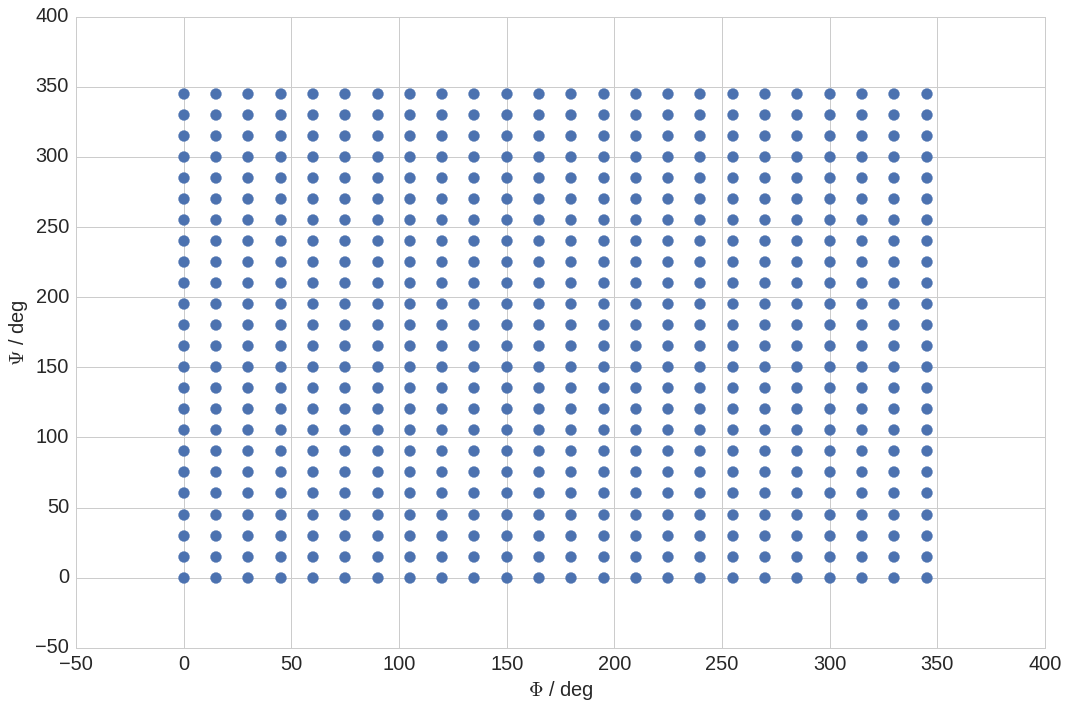

In [2]:
#Do not run, here I have extracted the energy from the output and put in a dictionary along with phi and psi keys
input_files = glob.glob("quantum_outputs/*/structure*.out")

dict_energy = {}
for f in input_files:
    phi = f.split("/")[1]
    psi = f.split("/")[-1].split(".out")[0].split("structure_")[1]
    gout = open(f,"r").readlines()
    #Extract energies
    scf = []
    for line in gout:
        if "SCF Done" in line:
            scf.append(line.split()[4])
    dict_energy[phi,psi] = scf[-1]
#print("Energy is")
#print(scf[-1])    
#plot the pairs of phi and psi that we have
phi = []
psi = []
for key in dict_energy:
    phi.append(int(key[0]))
    psi.append(int(key[1]))
    
fig,ax = plt.subplots(figsize=[15,10])
color=sbn.color_palette()
marker=['o','8']
plt.scatter(phi,psi,color=color[0],marker=marker[0],s=120)
plt.xlabel("$\Phi$ / deg",fontsize=20)
plt.ylabel("$\Psi$ / deg",fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()

#plt.savefig("PhiPsi_selection.png",dpi=600)

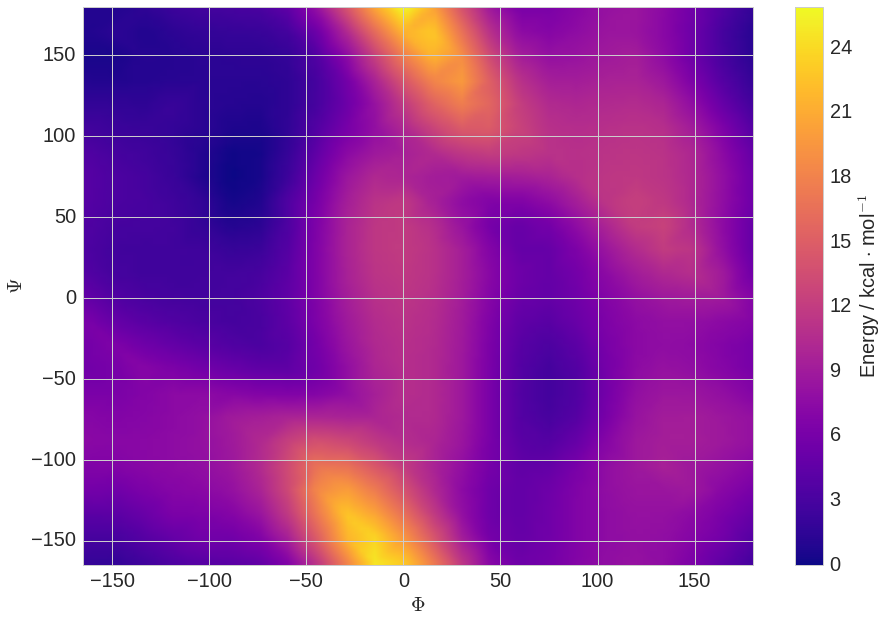

In [3]:
#Here I show an adiabatic plot with interpolation. The energy are rescaled so the min energy = 0
phi = []
psi = []
z = []
for key in dict_energy:
    val_phi = int(key[0])
    val_psi = int(key[1])
    if val_phi > 180.0:
        val_phi = val_phi -360.0
    if val_psi > 180.0:
        val_psi = val_psi -360.0
        
    phi.append(val_phi)
    psi.append(val_psi)
    z.append(float(dict_energy[key])*627.50) #kcal/mol
    
energies = []
#let's keep the relative energies with min = 0.0 
min_en = min(z)
counter = 0

for elem in z:
    scaled_en = elem - min_en
    energies.append(scaled_en)
       
#let's create all teh arrays
phi = asarray(phi)
psi = asarray(psi)
energies = asarray(energies)
#now create the meshgrid
xi,yi =  linspace(phi.min(),phi.max(),100), linspace(psi.min(),psi.max(),100)
xi,yi = meshgrid(xi,yi)

# Interpolate; there's also method='cubic' for 2-D data such as here
#rbf = scipy.interpolate.Rbf(x, y, z, function='linear')
#zi = rbf(xi, yi)
zi = interpolate.griddata((phi, psi), energies, (xi, yi), method='linear')


fig, ax = plt.subplots(figsize=(15,10))
cmap="plasma"
cax = ax.imshow(zi, vmin=energies.min(), vmax=energies.max(), origin='lower',
           extent=[phi.min(), phi.max(), psi.min(), psi.max()],aspect="auto",\
          cmap=cmap )
#17 is a good cutoff value
ax.set_xlabel("$\Phi$",fontsize=20)
ax.set_ylabel("$\Psi$",fontsize=20)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
cbar = fig.colorbar(cax)
cbar.ax.set_ylabel("Energy / kcal $\cdot$ mol$^{-1}$",fontsize=20)
cbar.ax.tick_params(labelsize=20)

plt.savefig("AdiabaticMap_HF.png",dpi=600)